In [1]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# your model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from tqdm import tqdm

from PIL import Image

In [7]:

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip', cache_subdir=os.path.abspath('.'), origin='http://images.cocodataset.org/zips/train2014.zip', extract=True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder

In [3]:
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip', cache_subdir=os.path.abspath('.'), origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip', extract=True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [8]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
    caption = f"<start> {val['caption']} <end>"
    image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
    image_path_to_caption[image_path].append(caption)

In [9]:
len(image_path_to_caption)

82783

In [10]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

train_image_paths = image_paths[:12000]
print(len(train_image_paths))

12000


In [11]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
    caption_list = image_path_to_caption[image_path]
    train_captions.extend(caption_list)
    img_name_vector.extend([image_path] * len(caption_list))

<start> there is a large bowl of broccoli and other foods <end>


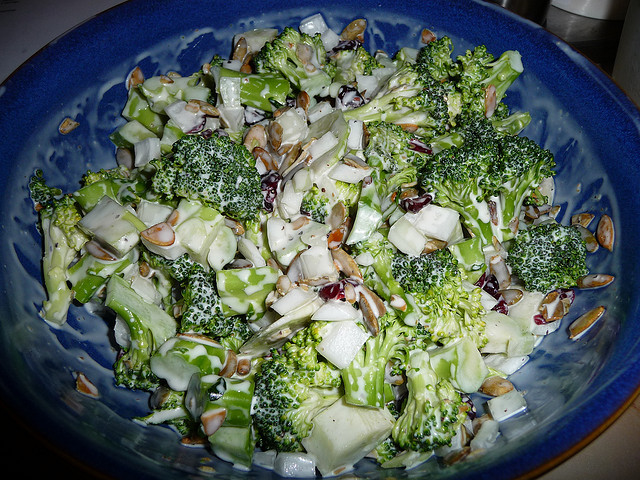

In [12]:
print(train_captions[0])
Image.open(img_name_vector[0])

In [13]:
image_size = 128

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (image_size, image_size))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [15]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [16]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

In [17]:
# Find the maximum length of any caption in the dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [18]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')
tokenizer.fit_on_texts(train_captions)

In [19]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [20]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [21]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [22]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(48019, 48019, 12006, 12006)

In [23]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [24]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [27]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [36]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [38]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [39]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [40]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [41]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [42]:
EPOCHS = 50

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

        print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
        print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 8 Batch 0 Loss 0.5983
Epoch 8 Batch 100 Loss 0.6081
Epoch 8 Batch 200 Loss 0.5741
Epoch 8 Batch 300 Loss 0.5244
Epoch 8 Batch 400 Loss 0.5889
Epoch 8 Batch 500 Loss 0.5684
Epoch 8 Batch 600 Loss 0.5616
Epoch 8 Batch 700 Loss 0.6335
Epoch 9 Batch 0 Loss 0.5718
Epoch 9 Batch 100 Loss 0.5435
Epoch 9 Batch 200 Loss 0.5601
Epoch 9 Batch 300 Loss 0.5711
Epoch 9 Batch 400 Loss 0.5424
Epoch 9 Batch 500 Loss 0.5696
Epoch 9 Batch 600 Loss 0.5828
Epoch 9 Batch 700 Loss 0.5424
Epoch 10 Batch 0 Loss 0.5649
Epoch 10 Batch 100 Loss 0.5426
Epoch 10 Batch 200 Loss 0.5468
Epoch 10 Batch 300 Loss 0.5574
Epoch 10 Batch 400 Loss 0.5177
Epoch 10 Batch 500 Loss 0.6021
Epoch 10 Batch 600 Loss 0.5206
Epoch 10 Batch 700 Loss 0.5374
Epoch 11 Batch 0 Loss 0.5477
Epoch 11 Batch 100 Loss 0.5216
Epoch 11 Batch 200 Loss 0.5575
Epoch 11 Batch 300 Loss 0.5419
Epoch 11 Batch 400 Loss 0.5319
Epoch 11 Batch 500 Loss 0.5585
Epoch 11 Batch 600 Loss 0.5203
Epoch 11 Batch 700 Loss 0.5846
Epoch 11 Loss 0.541656
Time take

Epoch 40 Batch 0 Loss 0.4058
Epoch 40 Batch 100 Loss 0.3648
Epoch 40 Batch 200 Loss 0.4299
Epoch 40 Batch 300 Loss 0.3804
Epoch 40 Batch 400 Loss 0.4551
Epoch 40 Batch 500 Loss 0.4179
Epoch 40 Batch 600 Loss 0.3985
Epoch 40 Batch 700 Loss 0.3999
Epoch 41 Batch 0 Loss 0.4552
Epoch 41 Batch 100 Loss 0.3556
Epoch 41 Batch 200 Loss 0.3789
Epoch 41 Batch 300 Loss 0.3536
Epoch 41 Batch 400 Loss 0.4291
Epoch 41 Batch 500 Loss 0.4115
Epoch 41 Batch 600 Loss 0.3681
Epoch 41 Batch 700 Loss 0.3919
Epoch 41 Loss 0.400530
Time taken for 1 epoch 134.92 sec

Epoch 42 Batch 0 Loss 0.4449
Epoch 42 Batch 100 Loss 0.4066
Epoch 42 Batch 200 Loss 0.4178
Epoch 42 Batch 300 Loss 0.3927
Epoch 42 Batch 400 Loss 0.4352
Epoch 42 Batch 500 Loss 0.3995
Epoch 42 Batch 600 Loss 0.3522
Epoch 42 Batch 700 Loss 0.3970
Epoch 43 Batch 0 Loss 0.4357
Epoch 43 Batch 100 Loss 0.3852
Epoch 43 Batch 200 Loss 0.3941
Epoch 43 Batch 300 Loss 0.3780
Epoch 43 Batch 400 Loss 0.4246
Epoch 43 Batch 500 Loss 0.3946
Epoch 43 Batch 600 L

In [43]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        #attention_plot[i] = attention_weights.numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result #, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    #attention_plot = attention_plot[:len(result), :]
    return result #, attention_plot

In [54]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

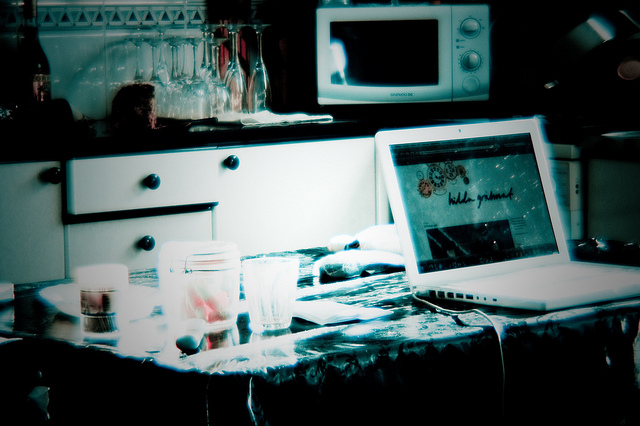

In [55]:
Image.open(image)

In [56]:
evaluate(image)

['a',
 'computer',
 'is',
 'open',
 'laptop',
 'as',
 'a',
 'desk',
 'with',
 'a',
 'desk',
 'with',
 'all',
 'on',
 'the',
 'bathroom',
 'peels',
 'off',
 'with',
 'a',
 'table',
 '<end>']